<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Factorization-Machine-(FM)" data-toc-modified-id="Factorization-Machine-(FM)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Factorization Machine (FM)</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Implementation</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

# Factorization Machines lab


**Factorization Machines** (FMs) are prediction/classification algorithms that combine traditional linear regression with advanced matrix factorization.

The *cool* idea behind FMs is to model interactions between features (aka. attributes, explanatory variables) using factorized parameters. 
By doing so, FMs have the ability to estimate all interactions between features even with extremely sparse data.

This presentation is largely taken from [an earlier work](http://ethen8181.github.io/machine-learning/recsys/factorization_machine/factorization_machine.html) by [Ethen](https://github.com/ethen8181/) who is gratefully acknowledged.



## Introduction

Normally, when we think of linear regression, we would think of the following formula:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i}
\end{align}

Where:

- $w_0$ is the bias term, a.k.a intercept.
- $w_i$ are weights corresponding to each feature vector $x_i$, here we assume we have $n$ total features.

This formula's advantage is that it can computed in linear time, $O(n)$. The drawback, however, is that it does not handle feature interactions. To capture interactions, we could introduce a weight for each feature combination. This is sometimes referred to as a $2_{nd}$ ordered polynomial. The resulting model is shown below:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} +  \sum_{i=1}^n \sum_{j=i+1}^n w_{ij} x_{i} x_{j}
\end{align}

Compared to our previous model, this formulation has the advantages that it can capture feature interactions at least for two features at a time. But we have now ended up with a $O(n^2)$ complexity which means that to train the model, we now require a lot more time and memory. Another issue is that when we have categorical variables with high cardinality, after one-hot encoding them, we would end up with a lot of columns that are sparse, making it harder to actually capture their interactions (not enough data).

To solve this complexity issue, Factorization Machines takes inspiration from [matrix factorization](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/recsys/1_ALSWR.ipynb), and models the feature interaction using latent factors. Every feature $f_i$ has a corresponding latent factor $v_i$, and two features' interactions are modelled as $\langle \textbf{v}_i, \textbf{v}_{j} \rangle$, where $\langle \cdot \;,\cdot \rangle$ refers to the dot product of the two feature vector. If we assume its of size $k$ (this is a hyperparameter that we can tune). Then:

\begin{align}
\langle \textbf{v}_i, \textbf{v}_{j} \rangle = \sum_{f=1}^k v_{i,f} v_{j,f}
\end{align}

This leads of our new equation:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \sum_{i=1}^{n} \sum_{j=i+1}^n \langle \textbf{v}_i , \textbf{v}_{j} \rangle x_i x_{j}
\end{align}

This is an improvement from our previous model (when we modeled each pair of interaction terms with weight $w_{ij}$) as the number of parameters is reduced from $n^2$ to $n \times k$, since $k \ll n$, which also helps mitigate overfitting issues. Using the naive way of formulating factorization machine results in a complexity of $O(kn^2)$, because all pairwise interactions have to be computed, but we can reformulate it to make it run in $O(kn)$.


\begin{align}
\sum_{i=1}^n \sum_{j=i+1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j}
&= \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j} - \frac{1}{2} \sum_{i=1}^n \langle \textbf{v}_i , \textbf{v}_{i} \rangle x_{i} x_{i}  \\
&= \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n \sum_{f=1}^k v_{i,f} v_{j,f} x_{i} x_{j} \right) - \frac{1}{2}\left( \sum_{i=1}^n \sum_{f=1}^k v_{i,f} v_{i,f} x_{i} x_{i} \right) \\
&= \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n \sum_{f=1}^k v_{i,f} v_{j,f} x_{i} x_{j}  -  \sum_{i=1}^n \sum_{f=1}^k v_{i,f} v_{i,f} x_{i} x_{i} \right) \\
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left(\sum_{i=1}^n v_{i,f}x_{i} \right) \left( \sum_{j=1}^n v_{j,f}x_{j} \right) - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right) \\
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}

Note, summing over different pairs is the same as summing over all pairs minus the self-interactions (divided by two). This is the reason why the value 1/2 is introduced from the beginning of the derivation.

This reformulated equation has a linear complexity in both $k$ and $n$, i.e. its computation is in $O(kn)$, substituting this new equation into the existing factorization machine formula, we end up with:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}

In a machine learning setting, factorization machine can be applied to different supervised prediction tasks:

- **Regression:**, in this case $\hat{y}(\textbf{x})$ can be used directly by minimizing the mean squared error between the model prediction and target value, e.g. $\frac{1}{N}\sum^{N}\big(y - \hat{y}(\textbf{x})\big)^2$
- **Classification:**, if we were to use it in a binary classification setting, we could then minimize the log loss, $\ln \big(e^{-y \cdot \hat{y}(\textbf{x})} + 1 \big)$, where $\sigma$ is the sigmoid/logistic function and $y \in {-1, 1}$.

To train factorization machine, we can use a gradient descent based optimization techniques, the parameters to be learned are $(w_0, \mathbf{w},$ and $\mathbf{V}$).

\begin{align}
\frac{\partial}{\partial\theta}\hat{y}(\textbf{x}) =
\begin{cases}
1,  & \text{if $\theta$ is $w_0$} \\
x_i, & \text{if $\theta$ is $w_i$} \\
x_i\sum_{j=1}^{n} v_{j,f}x_j - v_{i,f}x_{i}^2 & \text{if $\theta$ is $v_{i,f}$}
\end{cases}
\end{align}

- Notice that $\sum_{j=1}^n v_{j, f} x_j$ does not depend on $i$, thus it can be computed independently.
- The last formula above, can also be written as $x_i(\sum_{j=1}^{n} v_{j,f}x_j - v_{i,f}x_{i})$.
- In practice, we would throw in some L2 regularization to prevent overfitting.

As the next section contains implementation of the algorithm from scratch, the gradient of the log loss is also provided here for completeness. The predicted value $\hat{y}(\textbf{x})$ is replaced with $x$ for making the notation cleaner.


\begin{align}
\frac{d}{dx}\left[ \ln \big(e^{-yx} + 1 \big) \right] 
&= \frac{1}{e^{-yx} + 1} \cdot  \frac{d}{dx}\left[e^{-yx} + 1 \right] \\
&= \frac{\frac{d}{dx}\left[e^{-yx} \right] + \frac{d}{dx}\left[1 \right]}{e^{-yx} + 1} \\
&= \frac{e^{-yx} \cdot \frac{d}{dx}\left[-yx \right] + 0}{e^{-yx} + 1} \\
&= \frac{e^{-yx} \cdot -y}{e^{-yx} + 1} \\
&= -\frac{ye^{-yx}}{e^{-yx} + 1} \\
&= -\frac{y}{e^{yx} + 1}
\end{align}

---

**Advantages:** We'll now wrap up the theoretical section of factorization machine, with some of its advantages:

- We can observe from the model equation that it can be computed in linear time.
- By leveraging ideas from matrix factorization, we can estimate higher order interaction effects even under very sparse data.
- Compared to traditional matrix factorization methods, which is restricted to modeling a user-item matrix, we can leverage other user or item specific features making factorization machine more flexible.

## Implementation

For the implementation of factorization machine, we'll use a for loop based code as I personally find it easier to comprehend for the gradient update section. There are different ways to speed up for loop based code in Python, such as using [Cython or Numba](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/python/cython/cython.ipynb), here we'll be using Numba.

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
#data = load_breast_cancer(as_frame=True)
#data.target[[10, 50, 85]]

from sklearn import datasets

X, y = datasets.load_breast_cancer(return_X_y=True)

X, y = shuffle(X, y, random_state=42)

labelencoder_Y = LabelEncoder()

y = labelencoder_Y.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(X_train)

[[1.635e+01 2.329e+01 1.090e+02 ... 2.248e-01 4.824e-01 9.614e-02]
 [2.425e+01 2.020e+01 1.662e+02 ... 2.248e-01 3.222e-01 8.009e-02]
 [1.164e+01 1.833e+01 7.517e+01 ... 1.218e-01 2.806e-01 9.097e-02]
 ...
 [1.959e+01 2.500e+01 1.277e+02 ... 1.466e-01 2.293e-01 6.091e-02]
 [1.246e+01 1.989e+01 8.043e+01 ... 7.625e-02 2.685e-01 7.764e-02]
 [1.603e+01 1.551e+01 1.058e+02 ... 1.981e-01 3.019e-01 9.124e-02]]


In [ ]:
import numpy as np
from numba import njit
from tqdm import trange
from sklearn.base import BaseEstimator, ClassifierMixin


class FactorizationMachineClassifier(BaseEstimator, ClassifierMixin):
    """
    Factorization Machine [1]_ using Stochastic Gradient Descent.
    For binary classification only.

    Parameters
    ----------
    n_iter : int, default 10
        Number of iterations to train the algorithm.

    n_factors : int, default 10
        Number/dimension of features' latent factors.

    learning_rate : float, default 0.1
        Learning rate for the gradient descent optimizer.

    reg_coef : float, default 0.01
        Regularization strength for weights/coefficients.

    reg_factors : float, default 0.01
        Regularization strength for features' latent factors.

    random_state : int, default 1234
        Seed for the randomly initialized features latent factors

    verbose : bool, default True
        Whether to print progress bar while training.

    Attributes
    ----------
    intercept_ : double
        Intercept term, w0 based on the original notations.

    coef_ : 1d ndarray, shape [n_features,]
        Coefficients, w based on the original notations.

    feature_factors_ : 2d ndarray, shape [n_factors, n_features]
        Latent factors for all features. v based on the original
        notations. The learned factors can be viewed as the
        embeddings for each features. If a pair of features tends
        to co-occur often, then their embeddings should be
        close/similar (in terms of cosine similarity) to each other.

    history_ : list
        Loss function's history at each iteration, useful
        for evaluating whether the algorithm converged or not.

    References
    ----------
    .. [1] `S. Rendle Factorization Machines (2010)
            <http://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf>`_ 
    """

    def __init__(self, n_iter = 10, n_factors = 10,
                 learning_rate = 0.1, reg_coef = 0.01,
                 reg_factors = 0.01, random_state = 1234, verbose = False):
        self.n_iter = n_iter
        self.verbose = verbose
        self.reg_coef = reg_coef
        self.n_factors = n_factors
        self.reg_factors = reg_factors
        self.random_state = random_state
        self.learning_rate = learning_rate

    def fit(self, X, y):
        """
        Fit the model to the input data and label.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        y : 1d ndarray, shape [n_samples,]
            Training data's corresponding label.

        Returns
        -------
        self
        """

        n_samples, n_features = X.shape

        self.coef_ = np.zeros(n_features)

        self.intercept_ = 0.0

        # the factors are often initialized with a mean of 0 and standard deviation
        # of 1 / sqrt(number of latent factor specified)
        np.random.seed(self.random_state)

        self.feature_factors_ = np.random.normal(
            scale = 1 / np.sqrt(self.n_factors), size = (self.n_factors, n_features))
        
        # the gradient is implemented in a way that requires
        # the negative class to be labeled as -1 instead of 0
        y = y.copy().astype(np.int32)

        y[y == 0] = -1

        loop = range(self.n_iter)

        if self.verbose:
            loop = trange(self.n_iter)

        self.history_ = []
        #print(X)
        #print(X.indptr)
        #print(X.indices)
        for _ in loop:
            
            loss = _sgd_update(X.data, X.indptr, X.indices,
                               y, n_samples, n_features,
                               self.intercept_, self.coef_,
                               self.feature_factors_, self.n_factors,
                               self.learning_rate, self.reg_coef, self.reg_factors)
            #print(loss)
            
            self.history_.append(loss)

        return self

    def predict_proba(self, X):
        """
        Probability estimates. The returned estimates for
        all classes are ordered by the label of classes.

        Paramters
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            The probability of the sample for each class in the model.
        """
        pred = self._predict(X)

        pred_proba = 1.0 / (1.0 + np.exp(-pred))

        proba = np.vstack((1 - pred_proba, pred_proba)).T

        return proba

    def _predict(self, X):
        """Similar to _predict_instance but vectorized for all samples"""
        linear_output = X * self.coef_
        v = self.feature_factors_.T

        term = (X * v) ** 2 - (X.power(2) * (v ** 2))

        factor_output = 0.5 * np.sum(term, axis = 1)

        return self.intercept_ + linear_output + factor_output

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        pred_proba = self.predict_proba(X)[:, 1]

        return pred_proba.round().astype(np.int)


@njit
def _sgd_update(data, indptr, indices, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    """
    Compute the loss of the current iteration and update
    gradients accordingly.
    """
    loss = 0.0

    for i in range(n_samples):
        pred, summed = _predict_instance(data, indptr, indices, w0, w, v, n_factors, i)
        
        # calculate loss and its gradient
        loss += _log_loss(pred, y[i])

        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):

            feature = indices[index]

            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):

                feature = indices[index]
                
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss


@njit
def _predict_instance(data, indptr, indices, w0, w, v, n_factors, i):
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])
    
    # summed is the independent term that can be re-used
    # during the gradient update stage
    return pred, summed


@njit
def _log_loss(pred, y):
    """
    negative log likelihood of the
    current prediction and label, y.
    """
    return np.log(np.exp(-pred * y) + 1.0)

In [ ]:
from scipy.sparse import csr_matrix
#print(X_train)
#print(type(X_train))
X_train =csr_matrix(X_train, shape=(X_train.shape)) 
#print(X_train.toarray())
#print(X_train.toarray())
fm = FactorizationMachineClassifier(n_iter = 100, learning_rate = 0.001)
fm.fit(X_train.toarray(), Y_train)

AttributeError: ignored

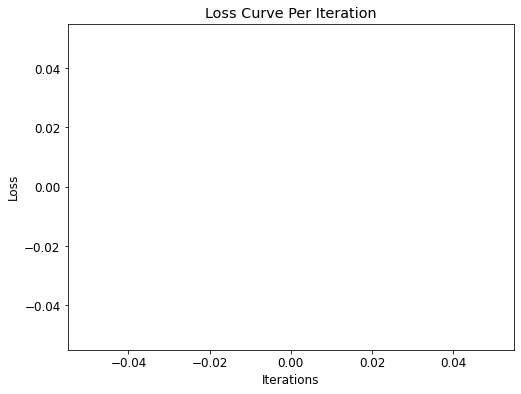

In [ ]:
# change default style figure and font size
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# one quick way to check that we've implemented
# the gradient descent is to ensure that the loss
# curve is steadily decreasing
plt.plot(fm.history_)
plt.title('Loss Curve Per Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
# predict on the test set and output the auc score
from sklearn.metrics import roc_auc_score
X_test = scipy.sparse.csr.csr_matrix(X_test, shape=(X_test.shape)) 
y_pred_prob = fm.predict_proba(X_test)
print(y_pred_prob)
auc = roc_auc_score(Y_test, y_pred_prob)
print('auc', auc)

[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]

<ipython-input-14-0e064af16a30>:3: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  X_test = scipy.sparse.csr.csr_matrix(X_test, shape=(X_test.shape))


ValueError: ignored

In [ ]:
# we can compare it with a logistic regression,
logreg = LogisticRegression()
logreg.fit(X_train_dtm, y_train)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('auc', auc)

auc 0.9949615178092


There are various open-sourced implementations floating around the web, here are the links to some of them:

- https://github.com/ibayer/fastFM
- https://github.com/srendle/libfm
- https://github.com/aksnzhy/xlearn
- https://github.com/scikit-learn-contrib/polylearn

I personally haven't tested which one is more efficient, feel free to grab one of them as see if it helps solve your problem.

# Reference

- [Blog: Factorization Machines](http://www.jefkine.com/recsys/2017/03/27/factorization-machines/)
- [Blog: Deep Understanding of FFM Principles and Practices (Chinese)](https://tech.meituan.com/deep-understanding-of-ffm-principles-and-practices.html)
- [Quora: What are the drawbacks of Factorization Machines?](https://www.quora.com/What-are-the-drawbacks-of-Factorization-Machines)
- [Paper: S. Rendle Factorization Machines (2010)](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)